In [1]:
import pandas as pd
import numpy as np
from khaiii import KhaiiiApi
import gensim
import pyLDAvis.gensim
import numpy as np
import logging
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import time
from pprint import pprint

/Users/uni613/Library/Python/3.8/lib/python/site-packages/past/types/oldstr.py:23: DeprecationWarning: invalid escape sequence \d
  """


In [2]:
data = pd.read_csv("./modi_data/kor_full.csv") ############
#data = data.drop(['Unnamed: 0'], axis=1)
data.head()

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,no,year,title,kor_full
0,1,1997,멀티미디어 원격교육에 관한 연구,멀티미디어 원격교육에 관한 연구
1,2,1997,교육용 하이퍼미디어 자료 편집기에 관한 연구,교육용 하이퍼미디어 자료 편집기에 관한 연구
2,3,1997,인터넷 기반의 코스웨어의 설계 및 구현,인터넷 기반의 코스웨어의 설계 및 구현
3,4,1997,Web에서의 협력 환경 구축 방안 연구,Web에서의 협력 환경 구축 방안 연구
4,5,1997,열린교육에서의 개별화수업과 CAI,열린교육에서의 개별화수업과 CAI


In [3]:
dfWordList = pd.read_excel("./khaiii_word_cor.xlsx")
dfWordList2 = pd.read_excel("./khaiii_word_cor_etc.xlsx")
#print(dfWordList2)

dfWordDel = dfWordList[dfWordList["수정"] == "삭제"]
dfWordMod = dfWordList[dfWordList["수정"] != "삭제"]
dfWordDiv = dfWordList2
#print(dfWordMod)

seriesDelete = dfWordDel["기존"]
stopword = []
for word in seriesDelete.values:
    stopword.append(word)
#print(stopword)

seriesModify = dfWordMod["기존"]
modiword = []
for word in seriesModify.values:
    modiword.append(word)
#print(len(modiword))

seriesModify2 = dfWordMod["수정"]
modiword2 = []
for word in seriesModify2.values:
    modiword2.append(word)
#print(len(modiword2))

seriesDivide = dfWordDiv["기존"]
divword = []
for word in seriesDivide.values:
    divword.append(word)
#print(divword)
#print(len(divword))

seriesDivide2 = dfWordDiv["수정"]
divword2 = []
for words in seriesDivide2.values:
    divword2.append(words.split(', '))
#print(divword2)
#print(len(divword2))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
api = KhaiiiApi()
def khaiiiTokenizer(raw, stopword=stopword, pos=['NNG', 'NNP', 'NNB', 'NP', 'NR', 'SL']): # 일반명사 고유명사 의존명사 대명사 수사 외국어
    list = []
    skip = 0

    for word in api.analyze(raw): #raw data
        #print(word)
        
        for i, morph in enumerate(word.morphs):
            #print(morph.lex)
            if skip == 1: 
                #print(morph.lex) # '지능'
                skip = 0
                continue

            if morph.lex == '인공' and i+1 < len(word.morphs) and word.morphs[i+1].lex == "지능":
                #print(morph.lex + word.morphs[i+1].lex) # 인공지능
                list.append(morph.lex + word.morphs[i+1].lex)
                skip = 1
                continue

            if len(morph.lex) > 1 and morph.tag in pos and morph.lex not in stopword: 
                if morph.tag == 'SL':
                    morph.lex = morph.lex.lower()
                if morph.lex in divword:
                    morph.lex = divword2[divword.index(morph.lex)]
                    list.extend(morph.lex)
                elif morph.lex in modiword:
                    morph.lex = modiword2[modiword.index(morph.lex)]
                    list.append(morph.lex)
                else: list.append(morph.lex)
                
    return list

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
tokenized = data["kor_full"].apply(lambda row: khaiiiTokenizer(row))
#print(tokenized)
#tokenized.to_excel("./final_data/1228token_khaiii_full.xls") ##############
print("========= tokenization completed =========")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
========= tokenization completed =========


In [6]:
#lda
id2word = gensim.corpora.Dictionary(tokenized)

wordlist = []
for i in range(len(id2word)):
    #print(id2word[i])
    wordlist.append(id2word[i])
#print(wordlist)
seriesWordlist = pd.Series(wordlist)
#seriesWordlist.to_excel("./final_data/1228wordlist_khaiii_full.xls") #################

corpus=[id2word.doc2bow(text) for text in tokenized]
#print("id2word for each document : ", corpus)
print("# words in total : ", len(id2word))
print("# documents : ", len(corpus))

# words in total :  5086
# documents :  1149
/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexity_values = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
        model_list.append(model)
        perplexitymodel = model.log_perplexity(corpus)
        perplexity_values.append(perplexitymodel)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, perplexity_values, coherence_values

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
start = time.time()
model_list, perplexity_values, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=tokenized,
                                                        start=2,
                                                        limit=31, #####
                                                        step=1)
print("time : ", ( time.time() - start )/60, "min")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
time :  3.8177374323209126 min


/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


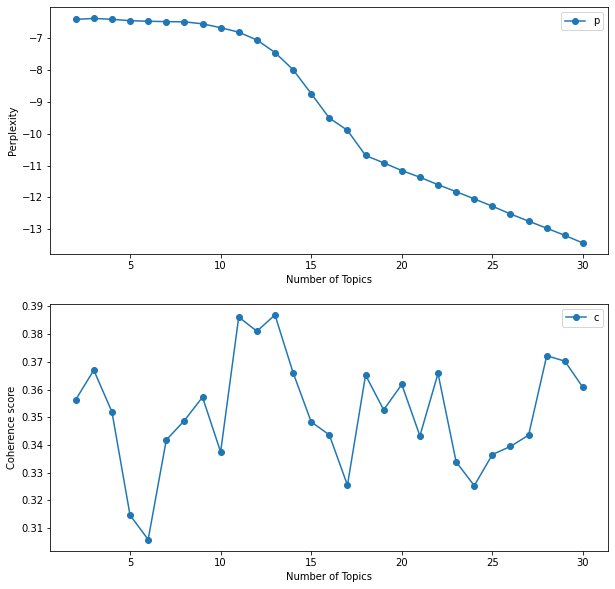

In [9]:
limit=31 ######
start=2
step=1
x = range(start, limit, step)


fig, ax = plt.subplots(2,1, figsize=(10, 10))

ax[0].plot(x, perplexity_values, marker='o')
ax[0].set_xlabel("Number of Topics")
ax[0].set_ylabel("Perplexity")
ax[0].legend(("perplexity"), loc='best')

ax[1].plot(x, coherence_values, marker='o')
ax[1].set_xlabel("Number of Topics")
ax[1].set_ylabel("Coherence score")
ax[1].legend(("coherence_values"), loc='best')
plt.show()

In [10]:
for m, pv in zip(x, perplexity_values):
  print("Num Topics =", m, " has Perplexity Value of", round(pv, 4))

for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Perplexity Value of -6.4156
Num Topics = 3  has Perplexity Value of -6.3847
Num Topics = 4  has Perplexity Value of -6.4121
Num Topics = 5  has Perplexity Value of -6.4551
Num Topics = 6  has Perplexity Value of -6.4728
Num Topics = 7  has Perplexity Value of -6.485
Num Topics = 8  has Perplexity Value of -6.4919
Num Topics = 9  has Perplexity Value of -6.5539
Num Topics = 10  has Perplexity Value of -6.6753
Num Topics = 11  has Perplexity Value of -6.8158
Num Topics = 12  has Perplexity Value of -7.0598
Num Topics = 13  has Perplexity Value of -7.4535
Num Topics = 14  has Perplexity Value of -7.9928
Num Topics = 15  has Perplexity Value of -8.7429
Num Topics = 16  has Perplexity Value of -9.5098
Num Topics = 17  has Perplexity Value of -9.895
Num Topics = 18  has Perplexity Value of -10.6831
Num Topics = 19  has Perplexity Value of -10.915
Num Topics = 20  has Perplexity Value of -11.1563
Num Topics = 21  has Perplexity Value of -11.3665
Num Topics = 22  has Perple

In [12]:
a = int(input("set the number of topics "))
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=a,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[(0,
  '0.072*"수업" + 0.052*"활용" + 0.050*"문제" + 0.041*"학생" + 0.041*"대상" + 0.040*"효과" '
  '+ 0.036*"적용" + 0.029*"연구" + 0.027*"모형" + 0.026*"중심" + 0.025*"학년" + '
  '0.025*"향상" + 0.023*"결과" + 0.023*"해결" + 0.021*"교과" + 0.021*"차이" + 0.019*"개발" '
  '+ 0.019*"콘텐츠" + 0.017*"태도" + 0.014*"검증" + 0.014*"전략" + 0.012*"스마트" + '
  '0.011*"신장" + 0.010*"인지" + 0.010*"실험" + 0.009*"만족도" + 0.009*"목표" + '
  '0.009*"능력" + 0.008*"디지털교과서" + 0.008*"초등"'),
 (1,
  '0.120*"인공지능" + 0.094*"ai" + 0.078*"데이터" + 0.078*"창의" + 0.071*"알고리즘" + '
  '0.040*"융합" + 0.037*"프로그램" + 0.028*"모델" + 0.026*"탐색" + 0.020*"분야" + '
  '0.015*"진행" + 0.012*"대학원" + 0.012*"steam" 

In [13]:
title = input("set the title of html file ")
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, title+".html")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# topic proportion
# num of optimal topics = 13

proportion = []
for i, row_list in enumerate(optimal_model[corpus]):
    #print("document number : ", i)
    row = row_list[0]
    #print(row)
    proportion.append(row)
print(pd.DataFrame(proportion))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
                    0                 1                  2                 3   \
0     (0, 0.116067335)  (1, 0.029412046)   (3, 0.016579244)  (4, 0.036357276)   
1      (0, 0.10398149)  (1, 0.027510323)   (3, 0.015507844)  (4, 0.033939064)   
2      (0, 0.11011843)  (1, 0.029404538)    (3, 0.01657921)  (4, 0.051973373)   
3      (0, 0.10179499)  (1, 0.025749361)  (3, 0.0145183075)   (4, 0.03177896)   
4      (0, 0.17446482)   (1, 0.02941813)   (3, 0.016582055)  (4, 0.035836574)   
...                ...               ...                ...               ...   
1144   (0, 0.12538837)  (3, 0.052045885)     (4, 0.2525328) 

In [16]:
proportion = []
for i, row_list in enumerate(optimal_model[corpus]):
    #print("document number : ", i)
    row = row_list[0]
    #print(row)
    inner_proportion = ["-", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-"] # numtopics 13
    for j, (topic_num, prop) in enumerate(row):
        for k in range(13): # numtopics 13
            if topic_num == k:
                inner_proportion[k] = prop
    proportion.append(inner_proportion)
    #print(inner_proportion)
#print(proportion)

#topic_proportions = pd.DataFrame(data["title"])

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
topic_proportions = pd.concat([data["title"], pd.DataFrame(proportion)], axis=1)
topic_proportions.columns = ["Title", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T10", "T11", "T12"] #num topics = 13
print(topic_proportions)
topic_proportions.to_excel("./final_data/0101_topic_proportions_total.xlsx")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
                                           Title        T0        T1 T2  \
0                              멀티미디어 원격교육에 관한 연구  0.116098  0.029412  -   
1                       교육용 하이퍼미디어 자료 편집기에 관한 연구  0.103981  0.027510  -   
2                          인터넷 기반의 코스웨어의 설계 및 구현  0.110118  0.029405  -   
3                          Web에서의 협력 환경 구축 방안 연구  0.101790  0.025749  -   
4                             열린교육에서의 개별화수업과 CAI  0.174465  0.029418  -   
...                                          ...       ...       ... ..   
1144        2015 개정 실과 교과서 소프트웨어 교육 단원 탐구성 비교 분석  0.125389         -  -   
1145            대화형 이러닝 콘텐츠